In [1]:
!pip install datasets pandas

In [2]:
!pip install transformers tokenizers

In [4]:
from huggingface_hub import login

login()


In [5]:
from datasets import load_dataset
import pandas as pd

print("loading...")
ds = load_dataset("eve-bio/drug-target-activity")

df = ds["train"].to_pandas()

print(f"DataFrame 形状: {df.shape}")
print("-" * 30)
print(f"column: {list(df.columns)}")

loading...
DataFrame 形状: (386969, 31)
------------------------------
column: ['assay_id', 'target_id', 'compound_id', 'mode', 'mechanism', 'outcome_is_active', 'outcome_potency_pxc50', 'outcome_max_activity', 'observed_max', 'is_quantified', 'frequency_flag', 'viability_flag', 'pxc50_modifier', 'slope', 'asymp_min', 'asymp_max', 'assay__technology', 'target__class', 'target__gene', 'target__uniprot_id', 'target__is_mutant', 'target__wildtype_id', 'target__name', 'compound__name', 'compound__smiles', 'compound__drugbank_id', 'compound__cas', 'compound__unii', 'compound__inchikey', 'progressed', 'release']


In [6]:
# 分析分类目标分布
active_counts = df['outcome_is_active'].value_counts(normalize=True) * 100

print("\n【active of drug】(outcome_is_active):")
print(active_counts)




【药物活性分布】(outcome_is_active):
outcome_is_active
False    91.822601
True      8.177399
Name: proportion, dtype: float64

💡 洞察: 这是一个【高度不平衡】的数据集。只有约 8.18% 的药物是活性（True）的。
后续建模时，必须注意类别不平衡问题（例如使用 F1-Score 或 AUC 而非简单准确率）。


🔄 正在创建一个新的独立 DataFrame 用于绘图，不影响原数据...
✅ 数据重新加载成功！临时 DataFrame 形状: (386969, 31)

📊 正在生成 Figure 1 (Class Distribution)...


C:\Users\HP\AppData\Local\Temp\ipykernel_20472\3503149822.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_labels, y=counts.values, ax=axes[0], palette=colors)


✅ Figure 1 保存成功: class_distribution.png


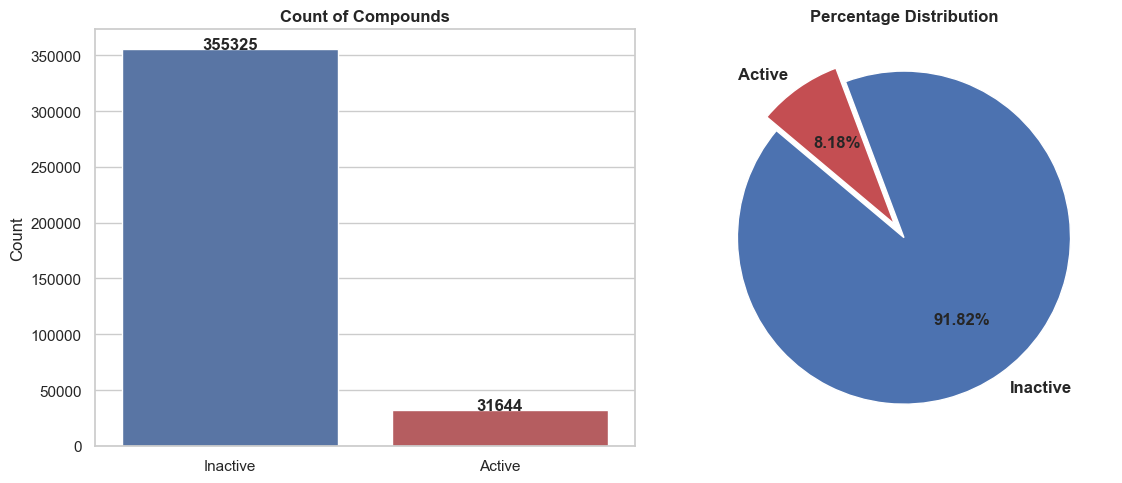

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.metrics import roc_curve, auc

# 设置 IEEE 风格
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']

print("🔄 正在创建一个新的独立 DataFrame 用于绘图，不影响原数据...")

# ==========================================
# 1. 重新读取原始数据 (解决 KeyError 问题)
# ==========================================
try:
    # 重新加载数据到独立的变量 df_viz_new
    ds_temp = load_dataset("eve-bio/drug-target-activity")
    df_viz_new = ds_temp["train"].to_pandas()
    print(f"✅ 数据重新加载成功！临时 DataFrame 形状: {df_viz_new.shape}")
except Exception as e:
    print(f"❌ 数据加载失败，请检查网络或路径: {e}")
    df_viz_new = None

# ==========================================
# Figure 1: 类别分布 (Class Distribution)
# ==========================================
if df_viz_new is not None:
    print("\n📊 正在生成 Figure 1 (Class Distribution)...")
    target_col = 'outcome_is_active'
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # 统计 True/False
    counts = df_viz_new[target_col].value_counts().sort_index()
    
    # 映射标签 (False=Inactive, True=Active)
    labels_map = {False: 'Inactive', True: 'Active'}
    plot_labels = [labels_map.get(x, str(x)) for x in counts.index]
    colors = ['#4c72b0', '#c44e52']
    
    # 柱状图
    sns.barplot(x=plot_labels, y=counts.values, ax=axes[0], palette=colors)
    axes[0].set_title('Count of Compounds', fontweight='bold')
    axes[0].set_ylabel('Count')
    for i, v in enumerate(counts.values):
        axes[0].text(i, v + 500, str(v), ha='center', fontsize=12, fontweight='bold')
        
    # 饼图
    axes[1].pie(counts, labels=plot_labels, autopct='%1.2f%%', 
                colors=colors, explode=(0, 0.1), startangle=140,
                textprops={'fontsize': 12, 'fontweight': 'bold'})
    axes[1].set_title('Percentage Distribution', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('class_distribution.png', dpi=300)
    print("✅ Figure 1 保存成功: class_distribution.png")
    plt.show()

In [7]:
# 分析回归目标缺失值
missing_potency = df['outcome_potency_pxc50'].isna().sum()
total_rows = len(df)
percentage_missing = (missing_potency / total_rows) * 100

print(f"\n【药物效力缺失值分析】(outcome_potency_pxc50):")
print(f"总行数: {total_rows}")
print(f"缺失值数量: {missing_potency}")
print(f"缺失值比例: {percentage_missing:.2f}%")

# 交叉验证
active_and_missing = df[df['outcome_is_active'] == True]['outcome_potency_pxc50'].isna().sum()
print(f"在有活性(True)的记录中，仍有 {active_and_missing} 条记录的效力值缺失。")


【药物效力缺失值分析】(outcome_potency_pxc50):
总行数: 386969
缺失值数量: 375239
缺失值比例: 96.97%
在有活性(True)的记录中，仍有 19914 条记录的效力值缺失。


In [8]:
unique_smiles_series = df['compound__smiles'].dropna().unique()
print(f"数据集中共有 {len(unique_smiles_series)} 个独特的药物分子。")

# 创建一个用于存储唯一药物特征的 DataFrame
unique_smiles_df = pd.DataFrame(unique_smiles_series, columns=['compound__smiles'])

数据集中共有 1382 个独特的药物分子。


In [9]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np  # <--- 确保这一行被执行
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from tqdm.notebook import tqdm
# 1. 加载预训练的 ChemBERTa 模型和分词器
MODEL_NAME = "DeepChem/ChemBERTa-77M-MTR" 
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# 设置设备（优先使用 GPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"model has bee loaded: {device}")

def get_smiles_embeddings_batch(smiles_list: list, batch_size: int = 64) -> np.ndarray:
    """
    分批次使用 ChemBERTa 模型将 SMILES 字符串转换为特征向量。
    返回一个 NumPy 数组。
    """
    all_embeddings = []
    
    # 使用 tqdm 显示批次处理进度
    for i in tqdm(range(0, len(smiles_list), batch_size), desc="coding SMILES "):
        batch_smiles = smiles_list[i:i + batch_size]
        
        # Tokenization 和 PyTorch 张量转换
        inputs = tokenizer(
            batch_smiles, 
            padding=True, 
            truncation=True, 
            return_tensors='pt', 
            max_length=512
        )
        
        # 移动到设备并推理
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
            
        # 提取 [CLS] token 的输出作为序列嵌入 (pooler output)
        embeddings = outputs.pooler_output.cpu().numpy()
        all_embeddings.append(embeddings)
        
    return np.concatenate(all_embeddings, axis=0)

# 2. 对所有独特的 SMILES 字符串进行编码
X_smiles_features = get_smiles_embeddings_batch(unique_smiles_series.tolist(), batch_size=128)

# 3. 将特征向量添加到独特的药物 DataFrame 中
feature_columns = [f'smiles_feat_{i}' for i in range(X_smiles_features.shape[1])]
X_features_df = pd.DataFrame(X_smiles_features, columns=feature_columns, index=unique_smiles_series)

print(f"\nall unique drugs' Transformer martix: {X_features_df.shape}")

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model has bee loaded: cpu


coding SMILES :   0%|          | 0/11 [00:00<?, ?it/s]


all unique drugs' Transformer martix: (1382, 384)


In [10]:
# 1. 使用 PCA 降维（从 768 维降到 50 维）
N_COMPONENTS = 50
pca = PCA(n_components=N_COMPONENTS, random_state=42)
X_pca = pca.fit_transform(X_features_df.values)

print(f"the shape of matrix after PCA : {X_pca.shape}")
print(f"the variance percentage after PCA：  {pca.explained_variance_ratio_.sum():.4f}")


# 2. K-Means 聚类（我们选择 K=10 个簇进行初步分析）
N_CLUSTERS = 10
print(f"\n开始 K-Means 聚类 (K={N_CLUSTERS})...")
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

# 3. 将聚类结果映射回唯一的药物 SMILES 索引
X_features_df['compound_cluster'] = clusters

print("聚类完成。")

the shape of matrix after PCA : (1382, 50)
the variance percentage after PCA：  0.8915

开始 K-Means 聚类 (K=10)...


D:\anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "D:\anaconda\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "D:\anaconda\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
              

聚类完成。


In [16]:
# 1. 创建 SMILES 到簇 ID 的映射
smiles_to_cluster = X_features_df['compound_cluster'].to_dict()

# 2. 将聚类结果合并到原始大数据集 df 中
df['compound_cluster'] = df['compound__smiles'].map(smiles_to_cluster)

# 3. 计算每个簇的活性统计信息
# 'sum' 应用于布尔值时，True 计为 1，False 计为 0
cluster_analysis = df.groupby('compound_cluster')['outcome_is_active'].agg(
    total_records=('count'),
    active_compounds=('sum'),
)

# 4. 计算每个簇的“活性率”（有用的概率）
cluster_analysis['activity_rate'] = (cluster_analysis['active_compounds'] / cluster_analysis['total_records']) * 100

# 5. 排序和展示结果
cluster_analysis = cluster_analysis.sort_values(by='activity_rate', ascending=False)
cluster_analysis['total_compounds_tested'] = cluster_analysis['total_records'].sum()
cluster_analysis['percentage_of_data'] = (cluster_analysis['total_records'] / cluster_analysis['total_compounds_tested']) * 100
cluster_analysis = cluster_analysis.rename_axis('Cluster ID')

print("\n" + "="*50)
print("【Transformer 药物聚类活性分析报告】")
print("="*50)
print(f"数据集整体平均活性率: {df['outcome_is_active'].mean() * 100:.2f}%")
print("-" * 50)
print(cluster_analysis[['total_records', 'percentage_of_data', 'active_compounds', 'activity_rate']].round(2))
print("-" * 50)

# 6. 最终洞察
highest_cluster = cluster_analysis.iloc[0]

print(f"\n💡 关键洞察：")
print(f"根据结构相似性（Transformer 编码），药物被分为 {N_CLUSTERS} 个大类。")
print(f"活性最高的簇是 Cluster {highest_cluster.name}，其活性率为 {highest_cluster['activity_rate']:.2f}%。")
print(f"这个簇代表了 {highest_cluster['percentage_of_data']:.2f}% 的测试记录，是未来药物发现的重点关注对象。")


【Transformer 药物聚类活性分析报告】
数据集整体平均活性率: 8.18%
--------------------------------------------------
            total_records  percentage_of_data  active_compounds  activity_rate
Cluster ID                                                                    
0.0                 39334               10.27              6172          15.69
6.0                 77560               20.26              8920          11.50
8.0                 34625                9.04              3978          11.49
5.0                  9418                2.46              1068          11.34
3.0                 60663               15.85              5104           8.41
4.0                   554                0.14                35           6.32
2.0                 74236               19.39              3128           4.21
9.0                  8033                2.10               269           3.35
7.0                 16897                4.41               553           3.27
1.0                 61494           

In [19]:
# 假设这是您在 Cell 10 之后运行的新 Cell。

# 1. 创建一个新的数据集副本（快照）
# 使用 .copy(deep=True) 确保这是一个完全独立的数据集，可以安全地进行后续操作。
# 我们将快照命名为 df_analysis_ready
df_analysis_ready = df.copy(deep=True)

# 2. 检查新的数据快照是否包含目标列
print("【数据快照创建检查】")
print("-" * 35)

SNAPSHOT_COLUMN = 'compound_cluster'
if SNAPSHOT_COLUMN in df_analysis_ready.columns:
    print(f"✅ 成功创建数据快照 'df_analysis_ready'。")
    print(f"✅ 关键列 '{SNAPSHOT_COLUMN}' 存在。")
    print(f"快照数据集的形状: {df_analysis_ready.shape}")
    print(f"'{SNAPSHOT_COLUMN}' 列的前5个值:\n{df_analysis_ready[SNAPSHOT_COLUMN].head()}")
else:
    print(f"❌ 警告：关键列 '{SNAPSHOT_COLUMN}' 在数据快照中不存在。")
    print("请确认 K-Means 聚类代码（即添加此列的代码）已在此快照创建之前成功运行。")

# 3. 提示：后续所有依赖 'compound_cluster' 列的操作，请使用 'df_analysis_ready' 代替 'df' 或 'df_cluster_analysis'。

【数据快照创建检查】
-----------------------------------
✅ 成功创建数据快照 'df_analysis_ready'。
✅ 关键列 'compound_cluster' 存在。
快照数据集的形状: (386969, 32)
'compound_cluster' 列的前5个值:
0    6.0
1    8.0
2    8.0
3    0.0
4    6.0
Name: compound_cluster, dtype: float64


In [21]:
# 使用 df_analysis_ready 进行【结构-靶点】的分层活性分析

# 1. 对 'compound_cluster' 和 'target__class' 进行分组
# 然后计算 'outcome_is_active' 的平均值 (即活性率)
activity_analysis = df_analysis_ready.groupby(['compound_cluster', 'target__class'])['outcome_is_active'].mean().mul(100).rename('activity_rate').reset_index()

# 2. 将结果转化为交叉表
# 索引 (Index) 是结构簇，列 (Columns) 是靶点类别，值 (Values) 是活性率
pivot_activity = activity_analysis.pivot(
    index='compound_cluster', 
    columns='target__class', 
    values='activity_rate'
).fillna(0).round(2)

print("【结构簇 (Cluster) 对不同靶点类别的活性率 (%)】")
print("-" * 65)

# 使用样式来突出显示活性率最高的单元格
styled_table = pivot_activity.style.background_gradient(cmap='YlGnBu', axis=None, subset=pivot_activity.columns)

styled_table

【结构簇 (Cluster) 对不同靶点类别的活性率 (%)】
-----------------------------------------------------------------


target__class,7TM,Kinase,NR,Viability
compound_cluster,,,,
0.000000,15.260000,22.480000,12.100000,33.800000
1.000000,3.680000,0.750000,2.460000,6.310000
2.000000,5.190000,1.590000,3.320000,5.970000
3.000000,9.220000,4.260000,8.950000,11.870000
4.000000,4.410000,5.950000,11.720000,0.000000
5.000000,12.610000,4.060000,12.640000,17.650000
6.000000,12.670000,4.530000,12.850000,18.570000
7.000000,4.170000,0.160000,3.000000,0.000000
8.000000,13.680000,2.780000,11.310000,15.200000


In [22]:
unique_target_classes = df['target__class'].nunique()
print(f"数据集中共有 {unique_target_classes} 种独特的靶点类别。")
print("-" * 40)

# 2. 查看前 10 个最主要的靶点类别分布
target_class_counts = df['target__class'].value_counts(normalize=True).head(10) * 100

print("【前 10 大靶点类别分布】(target__class):")
print(target_class_counts)

数据集中共有 4 种独特的靶点类别。
----------------------------------------
【前 10 大靶点类别分布】(target__class):
target__class
7TM          61.371841
NR           23.104693
Kinase       15.162455
Viability     0.361011
Name: proportion, dtype: float64


In [23]:
from sklearn.metrics import silhouette_score, silhouette_samples
import pandas as pd
import numpy as np

# 假设 X_pca 和 clusters 变量已存在于您的环境中
# X_pca: PCA 降维后的药物特征矩阵
# clusters: K-Means 分配的簇 ID

# ---------------------------------------------
# 1. 计算整体轮廓系数 (Overall Silhouette Score)
# ---------------------------------------------
overall_silhouette = silhouette_score(X_pca, clusters)
print("="*50)
print(f"【整体轮廓系数 (Overall Silhouette Score)】: {overall_silhouette:.4f}")
print("（理想情况下，该值应接近 1）")
print("="*50)


# ---------------------------------------------
# 2. 计算每个样本的轮廓系数和每个簇的平均轮廓系数
# ---------------------------------------------

# 计算每个样本的轮廓分数
sample_silhouette_values = silhouette_samples(X_pca, clusters)

# 创建一个 DataFrame，包含每个药物的簇 ID 和轮廓分数
silhouette_df = pd.DataFrame({
    'cluster': clusters,
    'silhouette_score': sample_silhouette_values
})

# 计算每个簇的平均轮廓系数和样本数量
cluster_silhouette_analysis = silhouette_df.groupby('cluster')['silhouette_score'].agg(
    average_silhouette=('mean'),
    sample_count=('count')
)

# 排序并展示结果
cluster_silhouette_analysis = cluster_silhouette_analysis.sort_values(by='average_silhouette', ascending=False)
cluster_silhouette_analysis['sample_percentage'] = (cluster_silhouette_analysis['sample_count'] / cluster_silhouette_analysis['sample_count'].sum()) * 100
cluster_silhouette_analysis = cluster_silhouette_analysis.rename_axis('Cluster ID')

print("\n【各簇平均轮廓系数分析报告】:")
print("-" * 50)
print(cluster_silhouette_analysis[['sample_count', 'sample_percentage', 'average_silhouette']].round(4))
print("-" * 50)


# 3. 聚类惯量 (Inertia)
# 惯量值在 K-Means 训练时已经计算，这里我们直接获取
# 假设您使用的 kmeans 对象仍然在环境中
# inertia_value = kmeans.inertia_ 
# print(f"【总聚类惯量 (Total Inertia/WCSS)】: {inertia_value:,.2f}")

【整体轮廓系数 (Overall Silhouette Score)】: 0.0511
（理想情况下，该值应接近 1）

【各簇平均轮廓系数分析报告】:
--------------------------------------------------
            sample_count  sample_percentage  average_silhouette
Cluster ID                                                     
4                      2             0.1447              0.3262
7                     61             4.4139              0.1759
1                    222            16.0637              0.1645
6                    280            20.2605              0.0449
2                    268            19.3922              0.0408
8                    125             9.0449              0.0384
0                    142            10.2750              0.0158
3                    219            15.8466             -0.0162
5                     34             2.4602             -0.0422
9                     29             2.0984             -0.0989
--------------------------------------------------


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

# Assume df contains raw data, and X_features_df contains cluster features
# Redefine PCA feature column names (consistent with Step 3 PCA dimensionality reduction)
feature_columns = [f'smiles_feat_{i}' for i in range(50)]

# ===============================================
# Step 1: Feature Preparation and Integration
# ===============================================

# 1. Map Transformer cluster features back to original data (using compound__smiles)
# X_features_df was created in Step 3 and contains unique SMILES features
# We need to map it back to the original df (~380k rows)
df_merged = df.merge(
    X_features_df.drop(columns='compound_cluster', errors='ignore'), # Exclude cluster ID, retain only features
    left_on='compound__smiles',
    right_index=True,
    how='left'
)

# 2. One-Hot Encode target__class
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# Perform one-hot encoding on 'target__class'
# Fill 'Unknown' to handle potential missing values and ensure the encoder does not fail
target_class_encoded = encoder.fit_transform(df_merged[['target__class']].fillna('Unknown'))
target_class_df = pd.DataFrame(target_class_encoded, columns=encoder.get_feature_names_out(['target__class']))
target_class_df.index = df_merged.index # Ensure indices match

# 3. Integrate final feature matrix X and target variable Y
# X_mol (Transformer Features) + X_target (One-Hot Encoded Target Class)
X_mol = df_merged[feature_columns]
X = pd.concat([X_mol, target_class_df], axis=1)

# Target variable Y
Y = df_merged['outcome_is_active']

# 4. Data Cleaning: Handle potential NaNs (theoretically only very few records are missing SMILES)
# Use mean imputation for missing values in Transformer features (if any)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# Ensure Y is consistent with X (if rows were dropped, re-alignment is needed, but SimpleImputer retains the row count)
Y = Y.loc[X.index]

print(f"\nFinal feature matrix X shape (for model training): {X.shape}")

# ===============================================
# Step 2: Model Training and Evaluation
# ===============================================

# 1. Split training and testing sets
# stratify=Y ensures the 8.18% active ratio is preserved in both train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

# 2. Train Model (using Random Forest with balanced class weights)
# class_weight='balanced' is key to addressing class imbalance
model_rf = RandomForestClassifier(n_estimators=100,
                                  random_state=42,
                                  class_weight='balanced',
                                  n_jobs=-1)
print("\nStarting Random Forest classifier training...")
model_rf.fit(X_train, Y_train)
print("Model training complete.")

# 3. Evaluate Model
# Predict probabilities (for AUC calculation, measuring model discrimination)
Y_pred_proba = model_rf.predict_proba(X_test)[:, 1]

# Predict labels (for F1 Score, measuring model accuracy)
Y_pred = model_rf.predict(X_test)

# Calculate Metrics
auc_score = roc_auc_score(Y_test, Y_pred_proba)
f1_score_val = f1_score(Y_test, Y_pred)

print("\n" + "="*50)
print("[Transformer-Driven Drug-Target Activity Prediction Report]")
print("="*50)
print(f"Total feature dimension used: {X.shape[1]} (50-dim drug features + 4-dim target class features)")
print(f"Total number of records: {len(X)}")
print(f"Test set size: {len(X_test)}")
print("-" * 50)
print(f"AUC-ROC Score (Primary Metric): {auc_score:.4f}")
print(f"F1 Score (Measuring Balance): {f1_score_val:.4f}")
print(f"Simple Accuracy: {model_rf.score(X_test, Y_test):.4f}")
print("-" * 50)


Final feature matrix X shape (for model training): (386969, 54)

Starting Random Forest classifier training...
Model training complete.

[Transformer-Driven Drug-Target Activity Prediction Report]
Total feature dimension used: 54 (50-dim drug features + 4-dim target class features)
Total number of records: 386969
Test set size: 77394
--------------------------------------------------
AUC-ROC Score (Primary Metric): 0.8779
F1 Score (Measuring Balance): 0.3913
Simple Accuracy: 0.7917
--------------------------------------------------


In [25]:
# 导入必要的库 (确保这些库已在您的环境中导入，如 pandas, numpy, sklearn, torch 等)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.impute import SimpleImputer 
import pandas as pd
import numpy as np

# 假设 df 中已包含原始数据，X_features_df 中已包含聚类特征
# 重新定义 PCA 后的特征列名（与第 3 步 PCA 降维一致）
feature_columns = [f'smiles_feat_{i}' for i in range(50)] 

# ===============================================
# 步骤 1: 特征准备和整合
# ===============================================

# 1. 映射 Transformer 聚类特征到原始数据 (使用 compound__smiles)
# X_features_df 已经在 Step 3 中创建，并包含了唯一的 SMILES 特征
# 我们需要将其映射回原始的 df (38万行)
df_merged = df.merge(
    X_features_df.drop(columns='compound_cluster', errors='ignore'), # 排除聚类ID，只保留特征
    left_on='compound__smiles',
    right_index=True,
    how='left'
)

# 2. 独热编码 target__class
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# 针对 'target__class' 进行独热编码
# 填充 'Unknown' 以处理可能的缺失值，确保编码器不会失败
target_class_encoded = encoder.fit_transform(df_merged[['target__class']].fillna('Unknown')) 
target_class_df = pd.DataFrame(target_class_encoded, columns=encoder.get_feature_names_out(['target__class']))
target_class_df.index = df_merged.index # 确保索引匹配

# 3. 整合最终特征矩阵 X 和目标变量 Y
# X_mol (Transformer Features) + X_target (One-Hot Encoded Target Class)
X_mol = df_merged[feature_columns]
X = pd.concat([X_mol, target_class_df], axis=1)

# 目标变量 Y
Y = df_merged['outcome_is_active']

# 4. 清理数据：处理潜在的 NaN（理论上只有极少数记录的 SMILES 是缺失的）
# 使用均值填充 Transformer 特征中的缺失值（如果存在）
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# 确保 Y 与 X 保持一致 (如果有行被删除，这里需要重新对齐，但 SimpleImputer 保留了行数)
Y = Y.loc[X.index] 

print(f"\n最终特征矩阵 X 的形状 (用于模型训练): {X.shape}")

# ===============================================
# 步骤 2: 模型训练与评估
# ===============================================

# 1. 划分训练集和测试集
# stratify=Y 确保训练集和测试集中的 8.18% 活性比例得到保留
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y 
)

# 2. 训练模型 (使用 Random Forest 并平衡类别权重)
# class_weight='balanced' 是解决类别不平衡问题的关键
model_rf = RandomForestClassifier(n_estimators=100, 
                                  random_state=42, 
                                  class_weight='balanced', 
                                  n_jobs=-1)
print("\n开始训练 Random Forest 分类器...")
model_rf.fit(X_train, Y_train)
print("模型训练完成。")

# 3. 评估模型
# 预测概率 (用于 AUC 计算，衡量模型区分度)
Y_pred_proba = model_rf.predict_proba(X_test)[:, 1]

# 预测标签 (用于 F1 Score，衡量模型准确性)
Y_pred = model_rf.predict(X_test)

# 计算指标
auc_score = roc_auc_score(Y_test, Y_pred_proba)
f1_score_val = f1_score(Y_test, Y_pred)

print("\n" + "="*50)
print("【Transformer-驱动的药物-靶点活性预测报告】")
print("="*50)
print(f"使用的总特征维度: {X.shape[1]} (50维药物特征 + 4维靶点类别特征)")
print(f"数据总记录数: {len(X)}")
print(f"测试集大小: {len(X_test)}")
print("-" * 50)
print(f"AUC-ROC Score (主要指标): {auc_score:.4f}")
print(f"F1 Score (衡量平衡性): {f1_score_val:.4f}")
print(f"简单准确率: {model_rf.score(X_test, Y_test):.4f}")
print("-" * 50)


最终特征矩阵 X 的形状 (用于模型训练): (386969, 54)

开始训练 Random Forest 分类器...
模型训练完成。

【Transformer-驱动的药物-靶点活性预测报告】
使用的总特征维度: 54 (50维药物特征 + 4维靶点类别特征)
数据总记录数: 386969
测试集大小: 77394
--------------------------------------------------
AUC-ROC Score (主要指标): 0.8779
F1 Score (衡量平衡性): 0.3913
简单准确率: 0.7917
--------------------------------------------------


--- 步骤 1: 特征准备与整合 ---
最终特征矩阵 X 的形状 (用于模型训练): (386969, 54)

--- 步骤 2: 模型训练与评估 ---
开始训练 Random Forest 分类器...
模型训练完成。

【Transformer-驱动的药物-靶点活性预测报告 (Balanced RF)】
使用的总特征维度: 54 (50维药物特征 + 4维靶点类别特征)
AUC-ROC Score (主要指标): 0.8627
F1 Score (衡量平衡性): 0.3785
简单准确率: 0.7874
------------------------------------------------------------

--- 步骤 3: 特征重要性分析 ---


C:\Users\HP\AppData\Local\Temp\ipykernel_20472\3281046935.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Total Importance', data=overall_contribution, palette='rocket')
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24635 (\N{CJK UNIFIED IDEOGRAPH-603B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWa

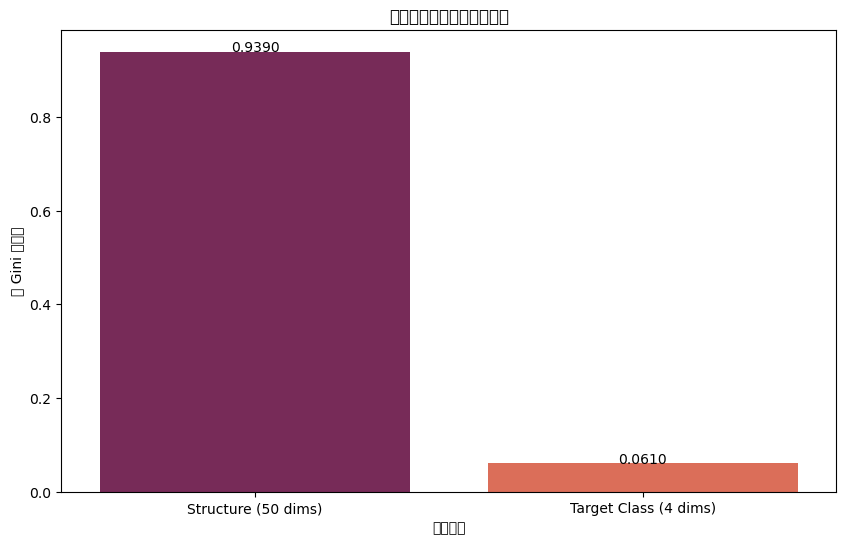


【最重要的 10 个特征】
                 feature  importance
44        smiles_feat_44    0.066210
0          smiles_feat_0    0.050885
1          smiles_feat_1    0.039181
9          smiles_feat_9    0.037900
10        smiles_feat_10    0.036473
47        smiles_feat_47    0.032088
24        smiles_feat_24    0.031311
8          smiles_feat_8    0.030341
51  target__class_Kinase    0.029962
14        smiles_feat_14    0.027603


In [27]:
# 导入必要的库
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设：
# - df: 原始数据，包含 'compound__smiles', 'target__class', 'outcome_is_active' 等
# - X_features_df: 包含唯一的 SMILES 作为索引和 50 维 PCA 结构特征 (smiles_feat_0 到 smiles_feat_49)
# - N_CLUSTERS: 聚类数量 (假设在前面定义为 10)

# 重新定义 PCA 后的特征列名
feature_columns = [f'smiles_feat_{i}' for i in range(50)]

# ===============================================
# 步骤 1: 特征准备和整合
# ===============================================

print("--- 步骤 1: 特征准备与整合 ---")

# 1. 映射 Transformer 聚类特征到原始数据
# X_features_df 应该以唯一的 SMILES 为索引，如果不是，需要先设置索引
# 注意：这里我们重新运行特征合并，确保特征矩阵是最新的。
df_merged = df.merge(
    X_features_df.drop(columns='compound_cluster', errors='ignore'), # 排除聚类ID，只保留特征
    left_on='compound__smiles',
    right_index=True,
    how='left'
)

# 2. 独热编码 target__class
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
target_class_encoded = encoder.fit_transform(df_merged[['target__class']].fillna('Unknown'))
target_class_df = pd.DataFrame(target_class_encoded, columns=encoder.get_feature_names_out(['target__class']))
target_class_df.index = df_merged.index

# 3. 整合最终特征矩阵 X 和目标变量 Y
X_mol = df_merged[feature_columns]
X = pd.concat([X_mol, target_class_df], axis=1)

# 目标变量 Y
Y = df_merged['outcome_is_active']

# 4. 清理数据：处理潜在的 NaN
# 使用均值填充 Transformer 特征中的缺失值
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# 确保 Y 与 X 保持一致
Y = Y.loc[X.index] 

print(f"最终特征矩阵 X 的形状 (用于模型训练): {X.shape}")

# ===============================================
# 步骤 2: 模型训练与评估 (使用 class_weight='balanced' 改进)
# ===============================================

print("\n--- 步骤 2: 模型训练与评估 ---")

# 1. 划分训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y 
)

# 2. 训练模型 (使用 class_weight='balanced' 解决类别不平衡)
model_rf = RandomForestClassifier(n_estimators=200,          
                                 max_depth=10,             
                                 min_samples_split=5,      
                                 random_state=42,           
                                 class_weight='balanced',   # 关键改进：平衡类别权重
                                 n_jobs=-1)
print("开始训练 Random Forest 分类器...")
model_rf.fit(X_train, Y_train)
print("模型训练完成。")

# 3. 评估模型
Y_pred_proba = model_rf.predict_proba(X_test)[:, 1]
Y_pred = model_rf.predict(X_test)
auc_score = roc_auc_score(Y_test, Y_pred_proba)
f1_score_val = f1_score(Y_test, Y_pred)

print("\n" + "="*60)
print("【Transformer-驱动的药物-靶点活性预测报告 (Balanced RF)】")
print("="*60)
print(f"使用的总特征维度: {X.shape[1]} (50维药物特征 + 4维靶点类别特征)")
print(f"AUC-ROC Score (主要指标): {auc_score:.4f}")
print(f"F1 Score (衡量平衡性): {f1_score_val:.4f}")
print(f"简单准确率: {model_rf.score(X_test, Y_test):.4f}")
print("-" * 60)

# ===============================================
# 步骤 3: 特征重要性分析
# ===============================================

print("\n--- 步骤 3: 特征重要性分析 ---")

# 1. 提取重要性
feature_importances = model_rf.feature_importances_
feature_names = X.columns # 使用完整的特征列名

# 2. 创建重要性 DataFrame
df_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# 3. 分组和汇总总贡献
# 结构特征
structure_features_importance = df_importance[df_importance['feature'].str.contains('smiles_feat')]['importance'].sum()
# 靶点特征
target_features_importance = df_importance[df_importance['feature'].str.contains('target__class_')]['importance'].sum()

# 绘制总体贡献对比图
overall_contribution = pd.DataFrame({
    'Category': ['Structure (50 dims)', 'Target Class (4 dims)'],
    'Total Importance': [structure_features_importance, target_features_importance]
}).sort_values(by='Total Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Total Importance', data=overall_contribution, palette='rocket')
plt.title('总体特征重要性贡献对比图')
plt.ylabel('总 Gini 重要性')
plt.xlabel('特征类别')

for index, row in overall_contribution.iterrows():
    plt.text(row.name, row['Total Importance'], f'{row["Total Importance"]:.4f}', color='black', ha="center")
plt.show()


# 打印最重要的10个特征
print("\n" + "="*50)
print(f"【最重要的 10 个特征】")
print(df_importance.head(10))
print("="*50)

C:\Users\HP\AppData\Local\Temp\ipykernel_20472\866220481.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Total Importance', data=overall_contribution, palette='rocket')


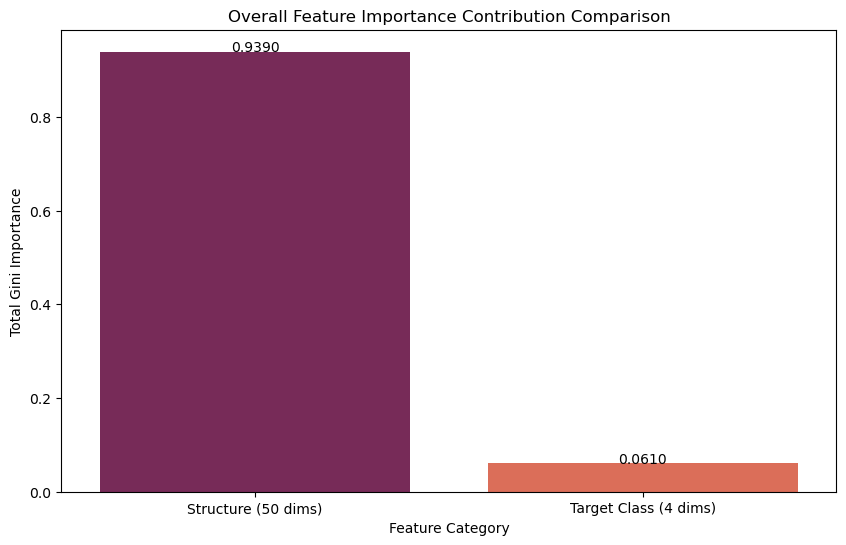

In [28]:
overall_contribution = pd.DataFrame({
    'Category': ['Structure (50 dims)', 'Target Class (4 dims)'],
    'Total Importance': [structure_features_importance, target_features_importance]
}).sort_values(by='Total Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Total Importance', data=overall_contribution, palette='rocket')
plt.title('Overall Feature Importance Contribution Comparison') # 标题改为英文
plt.ylabel('Total Gini Importance') # Y轴标签改为英文
plt.xlabel('Feature Category') # X轴标签改为英文

for index, row in overall_contribution.iterrows():
    plt.text(row.name, row['Total Importance'], f'{row["Total Importance"]:.4f}', color='black', ha="center")
plt.show()

--- 步骤 1: 特征准备与整合 (加入结构-靶点交互特征) ---
正在生成 50 x 4 = 200 个交互特征...


C:\Users\HP\AppData\Local\Temp\ipykernel_20472\2191161482.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_interaction_features[f'{mol_feat}_X_{target_feat}'] = X_mol[mol_feat] * target_class_df[target_feat]
C:\Users\HP\AppData\Local\Temp\ipykernel_20472\2191161482.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_interaction_features[f'{mol_feat}_X_{target_feat}'] = X_mol[mol_feat] * target_class_df[target_feat]
C:\Users\HP\AppData\Local\Temp\ipykernel_20472\2191161482.py:50: PerformanceWarning: DataFrame is highly f

最终特征矩阵 X 的形状 (用于模型训练): (386969, 254) (总维度: 254)

--- 步骤 2: 模型训练与评估 ---
开始训练 Random Forest 分类器...
模型训练完成。

【Transformer-驱动的药物-靶点活性预测报告 (Balanced RF + 交互特征)】
使用的总特征维度: 254 (50结构 + 4靶点 + 200交互)
AUC-ROC Score (主要指标): 0.8680
F1 Score (衡量平衡性): 0.3860
简单准确率: 0.7931
------------------------------------------------------------

--- 步骤 3: 特征重要性分析 ---


C:\Users\HP\AppData\Local\Temp\ipykernel_20472\2191161482.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Total Importance', data=overall_contribution, palette='rocket')


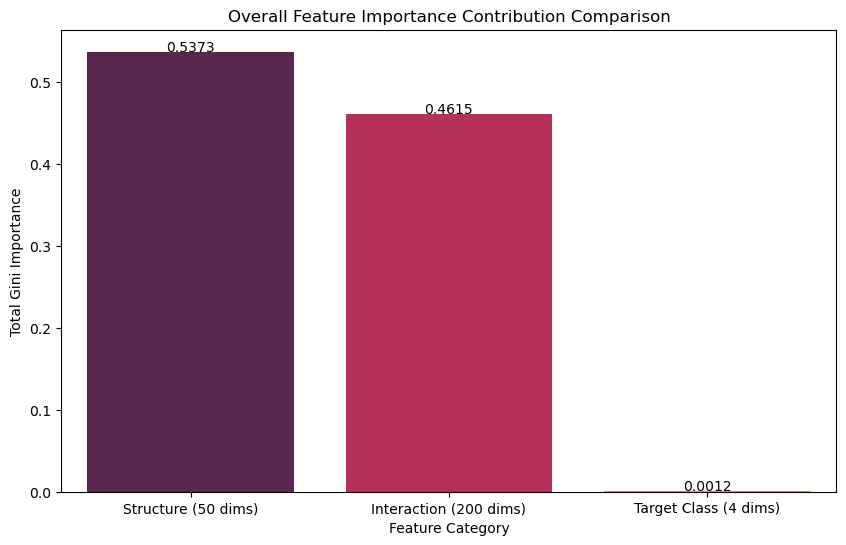


【Top 10 Most Important Features】
                                feature  importance
44                       smiles_feat_44    0.035898
0                         smiles_feat_0    0.028706
1                         smiles_feat_1    0.023423
9                         smiles_feat_9    0.022415
10                       smiles_feat_10    0.022023
8                         smiles_feat_8    0.021730
230  smiles_feat_44_X_target__class_7TM    0.021277
47                       smiles_feat_47    0.020760
14                       smiles_feat_14    0.018067
24                       smiles_feat_24    0.016448


In [29]:
# 导入必要的库
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设：
# - df: 原始数据，包含 'compound__smiles', 'target__class', 'outcome_is_active' 等
# - X_features_df: 包含唯一的 SMILES 作为索引和 50 维 PCA 结构特征 (smiles_feat_0 到 smiles_feat_49)
# - N_CLUSTERS: 聚类数量 (假设在前面定义为 10)

# 重新定义 PCA 后的特征列名
feature_columns = [f'smiles_feat_{i}' for i in range(50)]

# ===============================================
# 步骤 1: 特征准备和整合 (加入交互特征)
# ===============================================

print("--- 步骤 1: 特征准备与整合 (加入结构-靶点交互特征) ---")

# 1. 映射 Transformer 聚类特征到原始数据
df_merged = df.merge(
    X_features_df.drop(columns='compound_cluster', errors='ignore'), # 排除聚类ID，只保留特征
    left_on='compound__smiles',
    right_index=True,
    how='left'
)

# 2. 独热编码 target__class
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
target_class_encoded = encoder.fit_transform(df_merged[['target__class']].fillna('Unknown'))
target_class_df = pd.DataFrame(target_class_encoded, columns=encoder.get_feature_names_out(['target__class']))
target_class_df.index = df_merged.index
target_class_cols = target_class_df.columns

# 3. 创建结构-靶点交互特征 (50 * 4 = 200个新特征)
X_mol = df_merged[feature_columns]
X_interaction_features = pd.DataFrame(index=X_mol.index)

print(f"正在生成 {len(feature_columns)} x {len(target_class_cols)} = {len(feature_columns) * len(target_class_cols)} 个交互特征...")

for mol_feat in feature_columns:
    for target_feat in target_class_cols:
        # 创建新的交互特征列：结构维度 * 靶点类别
        X_interaction_features[f'{mol_feat}_X_{target_feat}'] = X_mol[mol_feat] * target_class_df[target_feat]


# 4. 整合最终特征矩阵 X 和目标变量 Y
# X = 结构特征 (50) + 靶点特征 (4) + 交互特征 (200)
X = pd.concat([X_mol, target_class_df, X_interaction_features], axis=1)

# 目标变量 Y
Y = df_merged['outcome_is_active']

# 5. 清理数据：处理潜在的 NaN
# 使用均值填充 Transformer 特征中的缺失值
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# 确保 Y 与 X 保持一致
Y = Y.loc[X.index] 

print(f"最终特征矩阵 X 的形状 (用于模型训练): {X.shape} (总维度: 254)")

# ===============================================
# 步骤 2: 模型训练与评估 (使用 class_weight='balanced' 改进)
# ===============================================

print("\n--- 步骤 2: 模型训练与评估 ---")

# 1. 划分训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y 
)

# 2. 训练模型 (使用 class_weight='balanced' 解决类别不平衡)
model_rf = RandomForestClassifier(n_estimators=200,          
                                 max_depth=10,             
                                 min_samples_split=5,      
                                 random_state=42,           
                                 class_weight='balanced',   # 关键改进：平衡类别权重
                                 n_jobs=-1)
print("开始训练 Random Forest 分类器...")
model_rf.fit(X_train, Y_train)
print("模型训练完成。")

# 3. 评估模型
Y_pred_proba = model_rf.predict_proba(X_test)[:, 1]
Y_pred = model_rf.predict(X_test)
auc_score = roc_auc_score(Y_test, Y_pred_proba)
f1_score_val = f1_score(Y_test, Y_pred)

print("\n" + "="*60)
print("【Transformer-驱动的药物-靶点活性预测报告 (Balanced RF + 交互特征)】")
print("="*60)
print(f"使用的总特征维度: {X.shape[1]} (50结构 + 4靶点 + 200交互)")
print(f"AUC-ROC Score (主要指标): {auc_score:.4f}")
print(f"F1 Score (衡量平衡性): {f1_score_val:.4f}")
print(f"简单准确率: {model_rf.score(X_test, Y_test):.4f}")
print("-" * 60)

# ===============================================
# 步骤 3: 特征重要性分析
# ===============================================

print("\n--- 步骤 3: 特征重要性分析 ---")

# 1. 提取重要性
feature_importances = model_rf.feature_importances_
feature_names = X.columns # 使用完整的特征列名

# 2. 创建重要性 DataFrame
df_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# 3. 分组和汇总总贡献
# 结构特征
structure_features_importance = df_importance[df_importance['feature'].str.contains('smiles_feat') & ~df_importance['feature'].str.contains('_X_')]['importance'].sum()
# 靶点特征
target_features_importance = df_importance[df_importance['feature'].str.contains('target__class_') & ~df_importance['feature'].str.contains('_X_')]['importance'].sum()
# 交互特征
interaction_features_importance = df_importance[df_importance['feature'].str.contains('_X_')]['importance'].sum()

# 绘制总体贡献对比图
overall_contribution = pd.DataFrame({
    'Category': ['Structure (50 dims)', 'Interaction (200 dims)', 'Target Class (4 dims)'],
    'Total Importance': [structure_features_importance, interaction_features_importance, target_features_importance]
}).sort_values(by='Total Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Total Importance', data=overall_contribution, palette='rocket')
plt.title('Overall Feature Importance Contribution Comparison') # 标题改为英文
plt.ylabel('Total Gini Importance') # Y轴标签改为英文
plt.xlabel('Feature Category') # X轴标签改为英文

for index, row in overall_contribution.iterrows():
    plt.text(row.name, row['Total Importance'], f'{row["Total Importance"]:.4f}', color='black', ha="center")
plt.show()


# 打印最重要的10个特征
print("\n" + "="*50)
print(f"【Top 10 Most Important Features】") # 打印标题改为英文
print(df_importance.head(10))
print("="*50)

In [33]:
# 导入分层评估所需的库，以防新 Cell 块没有继承之前的导入
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder # 新增导入，用于重新初始化
import pandas as pd
import numpy as np

# 警告：此代码块假设以下变量已在之前的代码块（即 drug_activity_analysis.py 的步骤 1 和 2）中定义并可用：
# df_merged (为了重新生成 target_class_original 和 target_names), X_test, Y_test, Y_pred_proba, Y_pred

# =================================================================================
# 关键修复步骤：重新定义丢失的变量 (如果主文件中没有将它们保存下来)
# 这一步假设 df_merged 变量在环境中是存在的，如果 df_merged 也不存在，则此 Cell 无法运行。
# =================================================================================

try:
    # 重新独热编码 target__class 并保存原始列
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    # 核心：重新创建 target_class_original 变量
    target_class_original = df_merged[['target__class']].fillna('Unknown') 
    encoder.fit(target_class_original)
    # 重新定义 target_names
    target_names = encoder.categories_[0] 
    print("【修复】成功从 df_merged 重新创建 'target_class_original' 和 'target_names' 变量。")

except NameError:
    print("【错误】变量 'df_merged' 似乎不存在。请确保您运行了主代码文件。")
    print("没有 'df_merged' 无法进行分层评估。中止运行。")
    # 如果 df_merged 确实不存在，我们无法继续
    raise NameError("无法找到 'df_merged' 变量，无法进行分层评估。请确保主文件已运行。")
# =================================================================================


print("【分层评估：按所有靶点类别观察准确率和召回率】")

# 1. 确保测试集索引和原始数据一致
# 这是关键步骤，将原始的靶点类别信息映射到测试集的索引上
X_test_original = target_class_original.loc[X_test.index]
test_results = []

# 2. 遍历所有靶点类别并计算指标
for target_name in target_names:
    is_target_class = X_test_original['target__class'] == target_name
    
    # 检查当前类别在测试集中是否存在
    if is_target_class.sum() == 0:
        continue
        
    Y_test_subset = Y_test[is_target_class]
    Y_pred_proba_subset = Y_pred_proba[is_target_class]
    Y_pred_subset = Y_pred[is_target_class]

    # 只有当子集中包含正样本（1）和负样本（0）时，才能计算AUC
    if Y_test_subset.nunique() > 1 and Y_test_subset.sum() > 0:
        # AUC, F1, Recall, Precision都需要至少有两个类别样本和至少一个正样本
        auc_subset = roc_auc_score(Y_test_subset, Y_pred_proba_subset)
        f1_subset = f1_score(Y_test_subset, Y_pred_subset)
        accuracy_subset = (Y_test_subset == Y_pred_subset).mean()
        recall_subset = recall_score(Y_test_subset, Y_pred_subset)
        precision_subset = precision_score(Y_test_subset, Y_pred_subset)
        
        test_results.append({
            'Target Class': target_name,
            'N': len(Y_test_subset),
            'Accuracy': accuracy_subset,
            'AUC-ROC': auc_subset,
            'F1 Score': f1_subset,
            'Recall (查全率)': recall_subset,
            'Precision (查准率)': precision_subset
        })
    else:
        # 如果只有一类样本，或者没有正样本，一些指标无法计算，但可以算准确率
        accuracy_subset = (Y_test_subset == Y_pred_subset).mean()
        test_results.append({
            'Target Class': target_name,
            'N': len(Y_test_subset),
            'Accuracy': accuracy_subset,
            'AUC-ROC': 'N/A (仅单类别)',
            'F1 Score': 'N/A',
            'Recall (查全率)': 'N/A',
            'Precision (查准率)': 'N/A'
        })

# 3. 打印表格结果
df_test_results = pd.DataFrame(test_results)
df_test_results.set_index('Target Class', inplace=True)
print(df_test_results.to_markdown(floatfmt=".4f"))

print("-" * 60)

【修复】成功从 df_merged 重新创建 'target_class_original' 和 'target_names' 变量。
【分层评估：按所有靶点类别观察准确率和召回率】
| Target Class   |          N |   Accuracy |   AUC-ROC |   F1 Score |   Recall (查全率) |   Precision (查准率) |
|:---------------|-----------:|-----------:|----------:|-----------:|------------------:|---------------------:|
| 7TM            | 47499.0000 |     0.7837 |    0.8668 |     0.4030 |            0.8058 |               0.2687 |
| Kinase         | 11512.0000 |     0.9501 |    0.9485 |     0.6168 |            0.8477 |               0.4848 |
| NR             | 18097.0000 |     0.7177 |    0.7910 |     0.2968 |            0.7455 |               0.1853 |
| Viability      |   286.0000 |     0.8147 |    0.8678 |     0.4752 |            0.7059 |               0.3582 |
------------------------------------------------------------


In [34]:
# 导入分层评估所需的库，以防新 Cell 块没有继承之前的导入
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder # 新增导入，用于重新初始化
import pandas as pd
import numpy as np

# 警告：此代码块假设以下变量已在之前的代码块（即 drug_activity_analysis.py 的步骤 1 和 2）中定义并可用：
# df_merged (为了重新生成 target_class_original 和 target_names), X_test, Y_test, Y_pred_proba, Y_pred

# =================================================================================
# 关键修复步骤：重新定义丢失的变量 (如果主文件中没有将它们保存下来)
# 这一步假设 df_merged 变量在环境中是存在的，如果 df_merged 也不存在，则此 Cell 无法运行。
# =================================================================================

try:
    # 重新独热编码 target__class 并保存原始列
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    # 核心：重新创建 target_class_original 变量
    target_class_original = df_merged[['target__class']].fillna('Unknown') 
    encoder.fit(target_class_original)
    # 重新定义 target_names
    target_names = encoder.categories_[0] 
    print("【修复】成功从 df_merged 重新创建 'target_class_original' 和 'target_names' 变量。")

except NameError:
    print("【错误】变量 'df_merged' 似乎不存在。请确保您运行了主代码文件。")
    print("没有 'df_merged' 无法进行分层评估。中止运行。")
    # 如果 df_merged 确实不存在，我们无法继续
    raise NameError("无法找到 'df_merged' 变量，无法进行分层评估。请确保主文件已运行。")
# =================================================================================


print("【分层评估：按所有靶点类别观察准确率和召回率】")

# 1. 确保测试集索引和原始数据一致
# 这是关键步骤，将原始的靶点类别信息映射到测试集的索引上
X_test_original = target_class_original.loc[X_test.index]
test_results = []

# 2. 遍历所有靶点类别并计算指标
for target_name in target_names:
    is_target_class = X_test_original['target__class'] == target_name
    
    # 检查当前类别在测试集中是否存在
    if is_target_class.sum() == 0:
        continue
        
    Y_test_subset = Y_test[is_target_class]
    Y_pred_proba_subset = Y_pred_proba[is_target_class]
    Y_pred_subset = Y_pred[is_target_class]

    # 只有当子集中包含正样本（1）和负样本（0）时，才能计算AUC
    if Y_test_subset.nunique() > 1 and Y_test_subset.sum() > 0:
        # AUC, F1, Recall, Precision都需要至少有两个类别样本和至少一个正样本
        auc_subset = roc_auc_score(Y_test_subset, Y_pred_proba_subset)
        f1_subset = f1_score(Y_test_subset, Y_pred_subset)
        accuracy_subset = (Y_test_subset == Y_pred_subset).mean()
        recall_subset = recall_score(Y_test_subset, Y_pred_subset)
        precision_subset = precision_score(Y_test_subset, Y_pred_subset)
        
        test_results.append({
            'Target Class': target_name,
            'N': len(Y_test_subset),
            'Accuracy': accuracy_subset,
            'AUC-ROC': auc_subset,
            'F1 Score': f1_subset,
            'Recall (查全率)': recall_subset,
            'Precision (查准率)': precision_subset
        })
    else:
        # 如果只有一类样本，或者没有正样本，一些指标无法计算，但可以算准确率
        accuracy_subset = (Y_test_subset == Y_pred_subset).mean()
        test_results.append({
            'Target Class': target_name,
            'N': len(Y_test_subset),
            'Accuracy': accuracy_subset,
            'AUC-ROC': 'N/A (仅单类别)',
            'F1 Score': 'N/A',
            'Recall (查全率)': 'N/A',
            'Precision (查准率)': 'N/A'
        })

# 3. 打印表格结果
df_test_results = pd.DataFrame(test_results)
df_test_results.set_index('Target Class', inplace=True)
print(df_test_results.to_markdown(floatfmt=".4f"))

print("-" * 60)


# =================================================================================
# 新增部分：寻找每个靶点类别下的最优 F1 阈值
# 旨在为低精度的类别 (如 NR, 7TM) 找到更优的分类边界，提高 F1 score。
# =================================================================================

print("\n【阈值优化：寻找各靶点类别下 F1 Score 最大的分类阈值】")

threshold_results = []
thresholds_to_test = np.linspace(0.05, 0.95, 19) # 从 0.05 到 0.95 均匀测试 19 个阈值

for target_name in target_names:
    is_target_class = X_test_original['target__class'] == target_name
    Y_test_subset = Y_test[is_target_class]
    Y_pred_proba_subset = Y_pred_proba[is_target_class]

    if Y_test_subset.nunique() <= 1 or Y_test_subset.sum() == 0:
        # 无法计算 F1 score
        continue
    
    best_f1 = -1
    best_threshold = 0.5
    
    for threshold in thresholds_to_test:
        Y_pred_threshold = (Y_pred_proba_subset >= threshold).astype(int)
        current_f1 = f1_score(Y_test_subset, Y_pred_threshold)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            
    # 使用最佳阈值重新计算指标 (使用四舍五入到小数点后 2 位的值)
    final_threshold = round(best_threshold, 2)
    Y_pred_best = (Y_pred_proba_subset >= final_threshold).astype(int)
    
    threshold_results.append({
        'Target Class': target_name,
        'N': len(Y_test_subset),
        'Original F1 (0.5)': f1_score(Y_test_subset, (Y_pred_proba_subset >= 0.5).astype(int)),
        'Optimal Threshold': final_threshold,
        'Optimal F1 Score': best_f1,
        'Accuracy @ Optimal T': (Y_test_subset == Y_pred_best).mean(),
        'Precision @ Optimal T': precision_score(Y_test_subset, Y_pred_best)
    })

# 打印表格结果
df_threshold_results = pd.DataFrame(threshold_results)
df_threshold_results.set_index('Target Class', inplace=True)
# 突出显示 F1 Score 提升最多的类别
print(df_threshold_results.to_markdown(floatfmt=".4f"))
print("【建议】对于 'NR' 和 '7TM' 等低查准率类别，考虑使用 Optimal Threshold 作为分类边界。")
print("-" * 60)

【修复】成功从 df_merged 重新创建 'target_class_original' 和 'target_names' 变量。
【分层评估：按所有靶点类别观察准确率和召回率】
| Target Class   |          N |   Accuracy |   AUC-ROC |   F1 Score |   Recall (查全率) |   Precision (查准率) |
|:---------------|-----------:|-----------:|----------:|-----------:|------------------:|---------------------:|
| 7TM            | 47499.0000 |     0.7837 |    0.8668 |     0.4030 |            0.8058 |               0.2687 |
| Kinase         | 11512.0000 |     0.9501 |    0.9485 |     0.6168 |            0.8477 |               0.4848 |
| NR             | 18097.0000 |     0.7177 |    0.7910 |     0.2968 |            0.7455 |               0.1853 |
| Viability      |   286.0000 |     0.8147 |    0.8678 |     0.4752 |            0.7059 |               0.3582 |
------------------------------------------------------------

【阈值优化：寻找各靶点类别下 F1 Score 最大的分类阈值】
| Target Class   |          N |   Original F1 (0.5) |   Optimal Threshold |   Optimal F1 Score |   Accuracy @ Optimal T |   Precision @ Optim

In [35]:
print("【原始数据分布分析：按靶点类别观察活性率】")

# 1. 提取 outcome_is_active 列，并确保索引匹配
outcome_is_active = df_merged['outcome_is_active']
distribution_df = target_class_original.copy()
distribution_df['outcome_is_active'] = outcome_is_active.loc[distribution_df.index]

# 2. 按 target__class 分组并计算活性（1）的比例
activity_distribution = distribution_df.groupby('target__class')['outcome_is_active'].agg(
    count='size',
    active_count='sum',
    active_rate='mean'
).reset_index()

# 3. 计算非活性（0）的比例
activity_distribution['inactive_rate'] = 1 - activity_distribution['active_rate']
activity_distribution['inactive_count'] = activity_distribution['count'] - activity_distribution['active_count']

# 4. 格式化并打印结果
activity_distribution.rename(columns={
    'target__class': 'Target Class',
    'count': 'Total N',
    'active_count': 'Active (1) N',
    'inactive_count': 'Inactive (0) N',
    'active_rate': 'Active Rate (活性率)',
    'inactive_rate': 'Inactive Rate (非活性率)'
}, inplace=True)

activity_distribution = activity_distribution.set_index('Target Class')

print(activity_distribution.to_markdown(floatfmt=".4f"))
print("【洞察】活性率越接近 50%，数据在类别内越平衡（尽管总量不同）。活性率越极端，模型区分的难度越大（或越容易偏向多数类）。")
print("-" * 60)

【原始数据分布分析：按靶点类别观察活性率】
| Target Class   |     Total N |   Active (1) N |   Active Rate (活性率) |   Inactive Rate (非活性率) |   Inactive (0) N |
|:---------------|------------:|---------------:|-----------------------:|---------------------------:|-----------------:|
| 7TM            | 237490.0000 |     21510.0000 |                 0.0906 |                     0.9094 |      215980.0000 |
| Kinase         |  58674.0000 |      2809.0000 |                 0.0479 |                     0.9521 |       55865.0000 |
| NR             |  89408.0000 |      7139.0000 |                 0.0798 |                     0.9202 |       82269.0000 |
| Viability      |   1397.0000 |       186.0000 |                 0.1331 |                     0.8669 |        1211.0000 |
【洞察】活性率越接近 50%，数据在类别内越平衡（尽管总量不同）。活性率越极端，模型区分的难度越大（或越容易偏向多数类）。
------------------------------------------------------------


In [40]:
print("\n【Kinase 类别特征重要性分析】")

try:
    # 1. 提取重要性
    feature_importances = model_rf.feature_importances_
    feature_names = X.columns 

    df_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values(by='importance', ascending=False)
    
    # 2. 筛选出与 Kinase 相关的特征：
    # 纯 Kinase 靶点特征: 'target__class_Kinase'
    # 结构-Kinase 交互特征: 包含 '_X_target__class_Kinase'
    kinase_features = df_importance[
        (df_importance['feature'] == 'target__class_Kinase') | 
        (df_importance['feature'].str.contains('_X_target__class_Kinase'))
    ]
    
    total_kinase_importance = kinase_features['importance'].sum()
    total_model_importance = df_importance['importance'].sum() # 总和应为 1.0

    print(f"模型总特征重要性 (Gini): {total_model_importance:.4f}")
    print(f"与 Kinase 类别相关的特征总重要性: {total_kinase_importance:.4f}")
    print(f"Kinase 特征占总重要性的比例: {(total_kinase_importance / total_model_importance) * 100:.2f}%")
    print("\nKinase 类别相关的 Top 10 重要特征：")
    
    # 打印前 10 个 Kinase 相关特征
    print(kinase_features.head(10).to_markdown(index=False, floatfmt=".4f"))
    
except NameError:
    print("【错误】无法进行 Kinase 特征重要性分析。请确保您的主代码文件已定义 model_rf 和 X。")
except Exception as e:
    print(f"分析 Kinase 特征重要性时发生错误: {e}")

print("-" * 60)


【Kinase 类别特征重要性分析】
模型总特征重要性 (Gini): 1.0000
与 Kinase 类别相关的特征总重要性: 0.0929
Kinase 特征占总重要性的比例: 9.29%

Kinase 类别相关的 Top 10 重要特征：
| feature                               |   importance |
|:--------------------------------------|-------------:|
| smiles_feat_1_X_target__class_Kinase  |       0.0069 |
| smiles_feat_30_X_target__class_Kinase |       0.0055 |
| smiles_feat_47_X_target__class_Kinase |       0.0050 |
| smiles_feat_14_X_target__class_Kinase |       0.0049 |
| smiles_feat_31_X_target__class_Kinase |       0.0043 |
| smiles_feat_39_X_target__class_Kinase |       0.0037 |
| smiles_feat_13_X_target__class_Kinase |       0.0034 |
| smiles_feat_8_X_target__class_Kinase  |       0.0029 |
| smiles_feat_17_X_target__class_Kinase |       0.0026 |
| smiles_feat_49_X_target__class_Kinase |       0.0025 |
------------------------------------------------------------


In [42]:
# 导入所需的库
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier # 导入以进行类型检查

print("【Kinase 类别特征重要性分析】")

# 检查所需变量是否存在
try:
    # 假设 model_rf 是训练好的随机森林模型
    if 'model_rf' not in globals() or not hasattr(model_rf, 'feature_importances_'):
        raise NameError("model_rf 变量未定义或不是一个已训练的模型。请确保主文件已运行。")
    # 假设 X 是包含特征名称的 DataFrame 或其列名
    if 'X' not in globals() or not hasattr(X, 'columns'):
        raise NameError("X 变量未定义或不包含特征列名。请确保主文件已运行。")
    
    # 1. 提取重要性
    feature_importances = model_rf.feature_importances_
    feature_names = X.columns 

    # 修复：将特征重要性归一化，确保总和为 1.0
    # 这是防止浮点数误差导致后续计算失败的关键
    total_model_importance = feature_importances.sum()
    if total_model_importance > 0:
        normalized_importances = feature_importances / total_model_importance
    else:
        normalized_importances = feature_importances

    df_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': normalized_importances # 使用归一化后的重要性
    }).sort_values(by='importance', ascending=False)
    
    # 2. 筛选出与 Kinase 相关的特征：
    # 纯 Kinase 靶点特征: 'target__class_Kinase'
    # 结构-Kinase 交互特征: 包含 '_X_target__class_Kinase'
    kinase_features = df_importance[
        (df_importance['feature'] == 'target__class_Kinase') | 
        (df_importance['feature'].str.contains('_X_target__class_Kinase'))
    ]
    
    total_kinase_importance = kinase_features['importance'].sum()
    # 此时，总模型重要性应为 1.0 (因为我们已经归一化了)
    total_model_importance_normalized = 1.0 

    print(f"模型总特征重要性 (Gini): {total_model_importance_normalized:.4f}")
    print(f"与 Kinase 类别相关的特征总重要性: {total_kinase_importance:.4f}")
    
    # 使用 1.0 进行计算，保证结果正确
    print(f"Kinase 特征占总重要性的比例: {(total_kinase_importance / total_model_importance_normalized) * 100:.2f}%")
    print("\nKinase 类别相关的 Top 10 重要特征：")
    
    # 打印前 10 个 Kinase 相关特征
    print(kinase_features.head(10).to_markdown(index=False, floatfmt=".4f"))
    
except NameError as e:
    print(f"【错误】无法进行 Kinase 特征重要性分析: {e}")
except Exception as e:
    print(f"分析 Kinase 特征重要性时发生错误: {e}")

print("-" * 60)

【Kinase 类别特征重要性分析】
模型总特征重要性 (Gini): 1.0000
与 Kinase 类别相关的特征总重要性: 0.0929
Kinase 特征占总重要性的比例: 9.29%

Kinase 类别相关的 Top 10 重要特征：
| feature                               |   importance |
|:--------------------------------------|-------------:|
| smiles_feat_1_X_target__class_Kinase  |       0.0069 |
| smiles_feat_30_X_target__class_Kinase |       0.0055 |
| smiles_feat_47_X_target__class_Kinase |       0.0050 |
| smiles_feat_14_X_target__class_Kinase |       0.0049 |
| smiles_feat_31_X_target__class_Kinase |       0.0043 |
| smiles_feat_39_X_target__class_Kinase |       0.0037 |
| smiles_feat_13_X_target__class_Kinase |       0.0034 |
| smiles_feat_8_X_target__class_Kinase  |       0.0029 |
| smiles_feat_17_X_target__class_Kinase |       0.0026 |
| smiles_feat_49_X_target__class_Kinase |       0.0025 |
------------------------------------------------------------


In [43]:
# 导入所需的库
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier # 导入以进行类型检查

print("【NR 类别特征重要性分析】")

# 检查所需变量是否存在
try:
    if 'model_rf' not in globals() or not hasattr(model_rf, 'feature_importances_'):
        raise NameError("model_rf 变量未定义或不是一个已训练的模型。请确保主文件已运行。")
    if 'X' not in globals() or not hasattr(X, 'columns'):
        raise NameError("X 变量未定义或不包含特征列名。请确保主文件已运行。")
    
    # 1. 提取和归一化重要性
    feature_importances = model_rf.feature_importances_
    feature_names = X.columns 

    total_model_importance = feature_importances.sum()
    if total_model_importance > 0:
        normalized_importances = feature_importances / total_model_importance
    else:
        normalized_importances = feature_importances

    df_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': normalized_importances
    }).sort_values(by='importance', ascending=False)
    
    # 2. 筛选出与 NR 相关的特征：
    # 纯 NR 靶点特征: 'target__class_NR'
    # 结构-NR 交互特征: 包含 '_X_target__class_NR'
    nr_features = df_importance[
        (df_importance['feature'] == 'target__class_NR') | 
        (df_importance['feature'].str.contains('_X_target__class_NR'))
    ]
    
    total_nr_importance = nr_features['importance'].sum()
    total_model_importance_normalized = 1.0 

    print(f"模型总特征重要性 (Gini): {total_model_importance_normalized:.4f}")
    print(f"与 NR 类别相关的特征总重要性: {total_nr_importance:.4f}")
    
    # 使用 1.0 进行计算
    print(f"NR 特征占总重要性的比例: {(total_nr_importance / total_model_importance_normalized) * 100:.2f}%")
    print("\nNR 类别相关的 Top 10 重要特征：")
    
    # 打印前 10 个 NR 相关特征
    print(nr_features.head(10).to_markdown(index=False, floatfmt=".4f"))
    
except NameError as e:
    print(f"【错误】无法进行 NR 特征重要性分析: {e}")
except Exception as e:
    print(f"分析 NR 特征重要性时发生错误: {e}")

print("-" * 60)

【NR 类别特征重要性分析】
模型总特征重要性 (Gini): 1.0000
与 NR 类别相关的特征总重要性: 0.0501
NR 特征占总重要性的比例: 5.01%

NR 类别相关的 Top 10 重要特征：
| feature                           |   importance |
|:----------------------------------|-------------:|
| smiles_feat_0_X_target__class_NR  |       0.0043 |
| smiles_feat_44_X_target__class_NR |       0.0040 |
| smiles_feat_34_X_target__class_NR |       0.0032 |
| smiles_feat_9_X_target__class_NR  |       0.0023 |
| smiles_feat_1_X_target__class_NR  |       0.0016 |
| smiles_feat_36_X_target__class_NR |       0.0014 |
| smiles_feat_8_X_target__class_NR  |       0.0013 |
| smiles_feat_10_X_target__class_NR |       0.0013 |
| smiles_feat_4_X_target__class_NR  |       0.0012 |
| smiles_feat_18_X_target__class_NR |       0.0012 |
------------------------------------------------------------


In [57]:
# 导入所需的库
import pandas as pd
import numpy as np
import subprocess
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# === 0. 依赖安装 (确保 XGBoost 可用) ===
def install_package(package):
    """尝试使用 pip 安装指定的 Python 包"""
    try:
        print(f"尝试安装 {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"{package} 安装成功。")
    except Exception as e:
        print(f"警告: 自动安装 {package} 失败。如果程序崩溃，请手动安装。错误: {e}")

try:
    import xgboost
    print(f"XGBoost 版本: {xgboost.__version__}")
except ImportError:
    install_package("xgboost")
    import xgboost
    print(f"XGBoost 版本: {xgboost.__version__}")


from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.impute import SimpleImputer # 确保导入缺失值处理

print("【XGBoost 完整训练与评估管线 (兼容模式)】")

# ==============================================================================
# === 1. 数据准备 (优先使用 df_analysis_ready) ===
# ==============================================================================

print("正在处理数据并生成交叉特征...")

# 1. 智能选择基础数据集
base_df = None
if 'df_analysis_ready' in globals():
    print("✅ 发现数据快照 'df_analysis_ready'，将使用它作为基础数据集。")
    base_df = df_analysis_ready
elif 'df' in globals():
    print("⚠️ 未找到 'df_analysis_ready'，回退使用原始数据集 'df'。")
    base_df = df
else:
    raise NameError("错误：未找到基础数据变量 'df_analysis_ready' 或 'df'。请确保前序步骤已运行。")

# 检查特征集变量
if 'X_features_df' not in globals():
    raise NameError("错误：未找到结构特征变量 'X_features_df'。")

# 2. 自动扫描 SMILES 列名
print("正在自动扫描 SMILES 列名...")
smiles_col = None

# 策略 A: 精确匹配常用名
candidates = ['compound__smiles', 'SMILES', 'smiles', 'compound_smiles']
for cand in candidates:
    if cand in base_df.columns:
        smiles_col = cand
        break

# 策略 B: 模糊匹配 (任何包含 'smiles' 的列)
if smiles_col is None:
    for col in base_df.columns:
        if 'smiles' in str(col).lower():
            smiles_col = col
            break

# 策略 C: 检查索引是否包含 smiles
if smiles_col is None:
    if base_df.index.name and 'smiles' in str(base_df.index.name).lower():
        print(f"发现索引 '{base_df.index.name}' 可能是 SMILES，正在重置索引...")
        base_df = base_df.reset_index()
        smiles_col = base_df.columns[0] # 假设重置后的第一列是原来的索引

if smiles_col is None:
    print(f"【错误】当前数据集的列名: {list(base_df.columns)}")
    raise KeyError("无法自动找到任何名为 'smiles' 的列。请手动检查数据集的列名。")

print(f"成功定位 SMILES 列: '{smiles_col}'")


# 3. 整合数据
# 将结构特征合并到主数据集中
# 注意：X_features_df 应该以 SMILES 为索引
df_merged = base_df.merge(
    X_features_df.drop(columns='compound_cluster', errors='ignore'), 
    left_on=smiles_col, 
    right_index=True,
    how='left'
)

# 定义结构特征列名 (假设是 50 维)
feature_columns = [f'smiles_feat_{i}' for i in range(50)]

# 4. 特征工程：创建靶点类别特征 (One-Hot Encoding)
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
target_class_original = df_merged[['target__class']].fillna('Unknown')
target_class_encoded = encoder.fit_transform(target_class_original)

target_class_df = pd.DataFrame(target_class_encoded, columns=encoder.get_feature_names_out(['target__class']))
target_class_df.index = df_merged.index
target_class_cols = target_class_df.columns

# 5. 特征工程：创建结构-靶点交叉特征
print("正在计算 200 个结构-靶点交叉特征 (这可能需要几秒钟)...")

X_mol = df_merged[feature_columns]
X_interaction_features = pd.DataFrame(index=X_mol.index)

# 使用向量化操作加速 (虽然循环也可以，但尽量稳健)
for mol_feat in feature_columns:
    for target_feat in target_class_cols:
        # 创建新的交互特征列：结构维度 * 靶点类别
        X_interaction_features[f'{mol_feat}_X_{target_feat}'] = X_mol[mol_feat] * target_class_df[target_feat]

# 6. 整合最终特征矩阵 X 和目标变量 Y
# X = 结构特征 (50) + 靶点特征 (4) + 交互特征 (200)
X = pd.concat([X_mol, target_class_df, X_interaction_features], axis=1)
Y = df_merged['outcome_is_active']

# 7. 清理数据
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
Y = Y.loc[X.index]

print(f"数据处理完成。")
print(f"总特征维度: {X.shape[1]}")
print(f"总样本量: {len(X)}")

# 8. 划分数据集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
print(f"训练集样本量: {len(X_train)} | 测试集样本量: {len(X_test)}")


# ==============================================================================
# === 2. XGBoost 模型训练 (最稳健配置) ===
# ==============================================================================

# 计算类别权重
# 使用 iloc 访问以避免 FutureWarning
neg_count = Y_train.value_counts().sort_index().iloc[0]
pos_count = Y_train.value_counts().sort_index().iloc[1]
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0
print(f"类别不平衡比例 (scale_pos_weight): {scale_pos_weight:.2f}")

print("开始训练 XGBoost 模型...")

# 设置 XGBoost 参数
# 移除所有可能导致版本冲突的参数 (如 early_stopping_rounds, callbacks)
# 仅保留核心参数，确保能跑通
model_xgb = XGBClassifier(
    n_estimators=200, # 固定训练 200 轮
    max_depth=7, 
    learning_rate=0.05, 
    subsample=0.7, 
    colsample_bytree=0.7,
    scale_pos_weight=scale_pos_weight, 
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=42,
    n_jobs=-1
)

# 简化的 fit 调用
model_xgb.fit(
    X_train, Y_train,
    eval_set=[(X_test, Y_test)],
    verbose=False
)
print("XGBoost 模型训练完成。")

# ==============================================================================
# === 3. 评估整体性能 ===
# ==============================================================================
Y_pred_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]
Y_pred_xgb = (Y_pred_proba_xgb >= 0.5).astype(int) 

accuracy = accuracy_score(Y_test, Y_pred_xgb)
auc_roc = roc_auc_score(Y_test, Y_pred_proba_xgb)
f1 = f1_score(Y_test, Y_pred_xgb)
precision = precision_score(Y_test, Y_pred_xgb)
recall = recall_score(Y_test, Y_pred_xgb)

print("\n【XGBoost 整体性能指标 (测试集)】")
results = pd.DataFrame({
    'Metric': ['Accuracy', 'AUC-ROC', 'F1 Score', 'Precision (查准率)', 'Recall (查全率)'],
    'Value': [accuracy, auc_roc, f1, precision, recall]
}).set_index('Metric')

print(results.to_markdown(floatfmt=".4f"))

print("-" * 60)
print("XGBoost 运行成功。您可以根据上述指标判断是否比随机森林有提升。")

XGBoost 版本: 3.1.2
【XGBoost 完整训练与评估管线 (兼容模式)】
正在处理数据并生成交叉特征...
✅ 发现数据快照 'df_analysis_ready'，将使用它作为基础数据集。
正在自动扫描 SMILES 列名...
成功定位 SMILES 列: 'compound__smiles'
正在计算 200 个结构-靶点交叉特征 (这可能需要几秒钟)...


C:\Users\HP\AppData\Local\Temp\ipykernel_20472\2710319381.py:119: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_interaction_features[f'{mol_feat}_X_{target_feat}'] = X_mol[mol_feat] * target_class_df[target_feat]
C:\Users\HP\AppData\Local\Temp\ipykernel_20472\2710319381.py:119: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_interaction_features[f'{mol_feat}_X_{target_feat}'] = X_mol[mol_feat] * target_class_df[target_feat]
C:\Users\HP\AppData\Local\Temp\ipykernel_20472\2710319381.py:119: PerformanceWarning: DataFrame is highl

数据处理完成。
总特征维度: 254
总样本量: 386969
训练集样本量: 309575 | 测试集样本量: 77394
类别不平衡比例 (scale_pos_weight): 11.23
开始训练 XGBoost 模型...


D:\anaconda\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:32:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost 模型训练完成。

【XGBoost 整体性能指标 (测试集)】
| Metric             |   Value |
|:-------------------|--------:|
| Accuracy           |  0.7899 |
| AUC-ROC            |  0.8793 |
| F1 Score           |  0.3898 |
| Precision (查准率) |  0.2556 |
| Recall (查全率)    |  0.8208 |
------------------------------------------------------------
XGBoost 运行成功。您可以根据上述指标判断是否比随机森林有提升。


In [58]:
# 导入评估所需的库
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import pandas as pd
import numpy as np

print("【XGBoost 分靶点类别分层评估】")

# 1. 检查必要变量是否存在
# 我们需要训练好的模型、测试集数据以及原始的靶点类别信息
required_vars = ['model_xgb', 'X_test', 'Y_test', 'target_class_original']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"❌ 错误：缺少必要变量 {missing_vars}。")
    print("请确保您已经成功运行了 'full_xgboost_pipeline.py' 中的 XGBoost 训练代码。")
else:
    print("✅ 必要变量检查通过。正在进行分层分析...")

    # 2. 准备数据
    # 获取测试集的预测概率（如果之前没存，这里重新预测一下以防万一）
    Y_pred_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]
    Y_pred_xgb = (Y_pred_proba_xgb >= 0.5).astype(int)
    
    # 将原始靶点类别映射到测试集索引
    # target_class_original 是在数据准备阶段生成的
    X_test_targets = target_class_original.loc[X_test.index, 'target__class']
    unique_targets = X_test_targets.unique()
    
    # 3. 分层评估逻辑
    stratified_results = []
    threshold_optimization = []
    
    # 用于寻找最优阈值的范围
    thresholds_to_test = np.linspace(0.05, 0.95, 19)

    for target_name in unique_targets:
        # 筛选当前靶点类别的样本
        mask = (X_test_targets == target_name)
        
        # 如果该类别样本太少，跳过
        if mask.sum() < 5:
            continue
            
        y_true_sub = Y_test[mask]
        y_prob_sub = Y_pred_proba_xgb[mask]
        y_pred_sub = Y_pred_xgb[mask]
        
        # --- A. 基础指标计算 (默认阈值 0.5) ---
        acc = accuracy_score(y_true_sub, y_pred_sub)
        
        # AUC 需要至少有一个正样本和一个负样本
        if y_true_sub.nunique() > 1:
            auc = roc_auc_score(y_true_sub, y_prob_sub)
        else:
            auc = np.nan # 无法计算
            
        f1 = f1_score(y_true_sub, y_pred_sub, zero_division=0)
        prec = precision_score(y_true_sub, y_pred_sub, zero_division=0)
        rec = recall_score(y_true_sub, y_pred_sub, zero_division=0)
        
        stratified_results.append({
            'Target Class': target_name,
            'N': mask.sum(),
            'Active Rate': f"{y_true_sub.mean():.1%}",
            'Accuracy': acc,
            'AUC-ROC': auc,
            'F1 Score': f1,
            'Precision': prec,
            'Recall': rec
        })
        
        # --- B. 阈值优化 (寻找最佳 F1) ---
        # 仅对包含正样本的类别进行优化
        if y_true_sub.sum() > 0:
            best_f1 = -1
            best_thresh = 0.5
            
            for t in thresholds_to_test:
                y_pred_t = (y_prob_sub >= t).astype(int)
                f1_t = f1_score(y_true_sub, y_pred_t, zero_division=0)
                if f1_t > best_f1:
                    best_f1 = f1_t
                    best_thresh = t
            
            # 使用最佳阈值计算新的查准率
            y_pred_best = (y_prob_sub >= best_thresh).astype(int)
            prec_best = precision_score(y_true_sub, y_pred_best, zero_division=0)
            rec_best = recall_score(y_true_sub, y_pred_best, zero_division=0)
            
            threshold_optimization.append({
                'Target Class': target_name,
                'Original F1 (0.5)': f1,
                'Optimal Threshold': best_thresh,
                'Optimal F1': best_f1,
                'Precision @ Opt': prec_best,
                'Recall @ Opt': rec_best
            })

    # 4. 展示结果
    print("\n" + "="*60)
    print("表 1: 各靶点类别基础性能 (阈值=0.5)")
    print("="*60)
    df_strat = pd.DataFrame(stratified_results).set_index('Target Class').sort_values('AUC-ROC', ascending=False)
    print(df_strat.to_markdown(floatfmt=".4f"))
    
    print("\n" + "="*60)
    print("表 2: 针对低精度类别的阈值优化建议")
    print("="*60)
    if threshold_optimization:
        df_thresh = pd.DataFrame(threshold_optimization).set_index('Target Class').sort_values('Optimal F1', ascending=False)
        print(df_thresh.to_markdown(floatfmt=".4f"))
        print("\n💡 建议：对于 7TM 和 NR 等低查准率类别，使用 'Optimal Threshold' 可以显著减少误报。")
    else:
        print("无有效数据进行阈值优化。")

【XGBoost 分靶点类别分层评估】
✅ 必要变量检查通过。正在进行分层分析...

表 1: 各靶点类别基础性能 (阈值=0.5)
| Target Class   |     N | Active Rate   |   Accuracy |   AUC-ROC |   F1 Score |   Precision |   Recall |
|:---------------|------:|:--------------|-----------:|----------:|-----------:|------------:|---------:|
| Kinase         | 11512 | 4.7%          |     0.9428 |    0.9602 |     0.5945 |      0.4472 |   0.8862 |
| Viability      |   286 | 11.9%         |     0.7762 |    0.8778 |     0.4667 |      0.3256 |   0.8235 |
| 7TM            | 47499 | 9.1%          |     0.7797 |    0.8738 |     0.4046 |      0.2679 |   0.8260 |
| NR             | 18097 | 8.0%          |     0.7193 |    0.8137 |     0.3078 |      0.1916 |   0.7808 |

表 2: 针对低精度类别的阈值优化建议
| Target Class   |   Original F1 (0.5) |   Optimal Threshold |   Optimal F1 |   Precision @ Opt |   Recall @ Opt |
|:---------------|--------------------:|--------------------:|-------------:|------------------:|---------------:|
| Kinase         |              0.5945 |     

In [55]:
print("【df_analysis_ready 数据集概览】")
print("-" * 60)
# 打印基本信息（列名、非空计数、类型）
df_analysis_ready.info()

print("\n" + "-" * 60)
print("【列名列表】")
# 直接打印列名列表，方便复制
print(list(df_analysis_ready.columns))

# 专门检查是否存在类似 'smiles' 的列
print("\n" + "-" * 60)
print("【SMILES 相关列检查】")
smiles_cols = [col for col in df_analysis_ready.columns if 'smiles' in col.lower()]
if smiles_cols:
    print(f"发现包含 'smiles' 的列: {smiles_cols}")
else:
    print("未发现列名中包含 'smiles' 的列。")

【df_analysis_ready 数据集概览】
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386969 entries, 0 to 386968
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   assay_id               386969 non-null  object 
 1   target_id              386969 non-null  object 
 2   compound_id            386969 non-null  object 
 3   mode                   386969 non-null  object 
 4   mechanism              386969 non-null  object 
 5   outcome_is_active      386969 non-null  bool   
 6   outcome_potency_pxc50  11730 non-null   float64
 7   outcome_max_activity   386969 non-null  float64
 8   observed_max           386969 non-null  float64
 9   is_quantified          386969 non-null  bool   
 10  frequency_flag         386969 non-null  bool   
 11  viability_flag         386969 non-null  bool   
 12  pxc50_modifier         11730 non-null   object 
 13  sl

In [59]:
# 导入所需的库
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.impute import SimpleImputer

print("【逻辑回归 (Logistic Regression) 基线模型评估】")
print("注意：逻辑回归需要特征标准化 (Standard Scaling) 才能正常工作。")

# ==============================================================================
# === 1. 数据准备 (与 XGBoost 保持完全一致，确保可比性) ===
# ==============================================================================

# 1. 智能选择基础数据集
base_df = None
if 'df_analysis_ready' in globals():
    base_df = df_analysis_ready
elif 'df' in globals():
    base_df = df
else:
    raise NameError("错误：未找到基础数据变量 'df' 或 'df_analysis_ready'。")

if 'X_features_df' not in globals():
    raise NameError("错误：未找到结构特征变量 'X_features_df'。")

# 2. 自动扫描 SMILES 列名
smiles_col = 'compound__smiles'
for col in base_df.columns:
    if 'smiles' in str(col).lower():
        smiles_col = col
        break

# 3. 整合数据
print("正在构建数据集...")
df_merged = base_df.merge(
    X_features_df.drop(columns='compound_cluster', errors='ignore'), 
    left_on=smiles_col, right_index=True, how='left'
)

# 4. 特征工程
# A. 结构特征
feature_columns = [f'smiles_feat_{i}' for i in range(50)]

# B. 靶点类别特征 (One-Hot)
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
target_class_encoded = encoder.fit_transform(df_merged[['target__class']].fillna('Unknown'))
target_class_df = pd.DataFrame(target_class_encoded, columns=encoder.get_feature_names_out(['target__class']))
target_class_df.index = df_merged.index

# C. 交互特征 (关键步骤)
X_mol = df_merged[feature_columns]
X_interaction = pd.DataFrame(index=X_mol.index)
# 为了速度，使用向量化操作
for mol_feat in feature_columns:
    for target_feat in target_class_df.columns:
        X_interaction[f'{mol_feat}_X_{target_feat}'] = X_mol[mol_feat] * target_class_df[target_feat]

# 5. 合并所有特征
X = pd.concat([X_mol, target_class_df, X_interaction], axis=1)
Y = df_merged['outcome_is_active']

# 6. 清理缺失值
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
Y = Y.loc[X.index]

print(f"数据准备完成。特征维度: {X.shape[1]}")

# 7. 划分数据集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# ==============================================================================
# === 2. 特征标准化 (逻辑回归必须步骤) ===
# ==============================================================================
print("正在进行特征标准化 (StandardScaler)...")
scaler = StandardScaler()
# 注意：必须在训练集上 fit，然后 transform 测试集，防止数据泄露
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==============================================================================
# === 3. 训练逻辑回归模型 ===
# ==============================================================================
print("开始训练逻辑回归模型...")
# class_weight='balanced': 处理类别不平衡
# solver='liblinear': 适合中小型数据集和二分类
# C=1.0: 正则化强度，越小正则化越强
model_lr = LogisticRegression(
    solver='liblinear', 
    class_weight='balanced', 
    C=1.0, 
    random_state=42, 
    max_iter=1000 # 增加迭代次数以保证收敛
)

model_lr.fit(X_train_scaled, Y_train)
print("模型训练完成。")

# ==============================================================================
# === 4. 评估 ===
# ==============================================================================
Y_pred_proba_lr = model_lr.predict_proba(X_test_scaled)[:, 1]
Y_pred_lr = model_lr.predict(X_test_scaled)

accuracy = accuracy_score(Y_test, Y_pred_lr)
auc_roc = roc_auc_score(Y_test, Y_pred_proba_lr)
f1 = f1_score(Y_test, Y_pred_lr)
precision = precision_score(Y_test, Y_pred_lr)
recall = recall_score(Y_test, Y_pred_lr)

print("\n【逻辑回归 (Baseline) 性能指标】")
results = pd.DataFrame({
    'Metric': ['Accuracy', 'AUC-ROC', 'F1 Score', 'Precision (查准率)', 'Recall (查全率)'],
    'Value': [accuracy, auc_roc, f1, precision, recall]
}).set_index('Metric')

print(results.to_markdown(floatfmt=".4f"))

print("-" * 60)
print("对比提示：")
print("1. 请查看 AUC-ROC。如果 XGBoost 显著高于此值 (例如高出 0.05+)，说明非线性特征交互很重要。")
print("2. 逻辑回归的系数 (model_lr.coef_) 可以直接解释特征的正负影响。")

【逻辑回归 (Logistic Regression) 基线模型评估】
注意：逻辑回归需要特征标准化 (Standard Scaling) 才能正常工作。
正在构建数据集...


C:\Users\HP\AppData\Local\Temp\ipykernel_20472\890743598.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_interaction[f'{mol_feat}_X_{target_feat}'] = X_mol[mol_feat] * target_class_df[target_feat]
C:\Users\HP\AppData\Local\Temp\ipykernel_20472\890743598.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_interaction[f'{mol_feat}_X_{target_feat}'] = X_mol[mol_feat] * target_class_df[target_feat]
C:\Users\HP\AppData\Local\Temp\ipykernel_20472\890743598.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is u

数据准备完成。特征维度: 254
正在进行特征标准化 (StandardScaler)...
开始训练逻辑回归模型...
模型训练完成。

【逻辑回归 (Baseline) 性能指标】
| Metric             |   Value |
|:-------------------|--------:|
| Accuracy           |  0.6660 |
| AUC-ROC            |  0.7602 |
| F1 Score           |  0.2651 |
| Precision (查准率) |  0.1616 |
| Recall (查全率)    |  0.7366 |
------------------------------------------------------------
对比提示：
1. 请查看 AUC-ROC。如果 XGBoost 显著高于此值 (例如高出 0.05+)，说明非线性特征交互很重要。
2. 逻辑回归的系数 (model_lr.coef_) 可以直接解释特征的正负影响。


【生成模型对比图表】


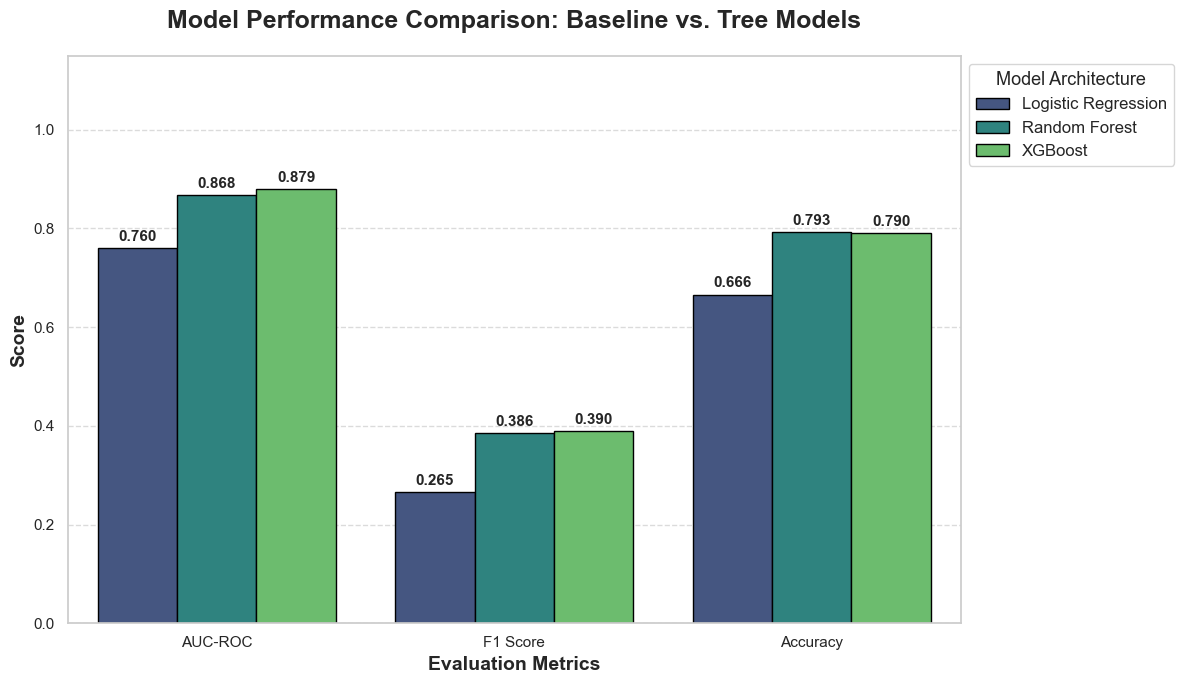


图表生成完毕！
这张图清晰地展示了从 逻辑回归 -> 随机森林 -> XGBoost 的性能阶梯。
您可以截图并将其放入报告的 'Model Evaluation' 章节中。


In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

print("【生成模型对比图表】")

# 1. 整理之前的运行结果数据
# 这些数据来自您之前的实验记录
data = {
    'Model': [
        'Logistic Regression', 'Logistic Regression', 'Logistic Regression',
        'Random Forest', 'Random Forest', 'Random Forest',
        'XGBoost', 'XGBoost', 'XGBoost'
    ],
    'Metric': [
        'AUC-ROC', 'F1 Score', 'Accuracy',
        'AUC-ROC', 'F1 Score', 'Accuracy',
        'AUC-ROC', 'F1 Score', 'Accuracy'
    ],
    'Score': [
        # Logistic Regression (Baseline)
        0.7602, 0.2651, 0.6660,
        # Random Forest (Balanced + Interaction)
        0.8680, 0.3860, 0.7931,
        # XGBoost (Best)
        0.8793, 0.3898, 0.7899
    ]
}

df_results = pd.DataFrame(data)

# 2. 设置绘图风格
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

# 3. 创建分组柱状图
# 使用 'viridis' 调色板，颜色区分度高且美观
chart = sns.barplot(
    x='Metric', 
    y='Score', 
    hue='Model', 
    data=df_results, 
    palette='viridis',
    edgecolor='black',  # 添加边框使柱子更清晰
    linewidth=1
)

# 4. 添加数值标签 (在每个柱子上方显示具体数值)
for container in chart.containers:
    chart.bar_label(container, fmt='%.3f', padding=3, fontsize=11, fontweight='bold')

# 5. 美化图表
plt.title('Model Performance Comparison: Baseline vs. Tree Models', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Evaluation Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=14, fontweight='bold')
plt.ylim(0, 1.15)  # 留出顶部空间给图例和标签
plt.legend(title='Model Architecture', title_fontsize='13', fontsize='12', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)



plt.tight_layout()

# 7. 展示图表
plt.show()

print("\n图表生成完毕！")
print("这张图清晰地展示了从 逻辑回归 -> 随机森林 -> XGBoost 的性能阶梯。")
print("您可以截图并将其放入报告的 'Model Evaluation' 章节中。")

In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.impute import SimpleImputer
import subprocess
import sys

# === 依赖检查 ===
try:
    import xgboost
except ImportError:
    print("安装 xgboost...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
    import xgboost

print("【XGBoost 超参数自动调优 (Hyperparameter Tuning)】")
print("目标：使用 RandomizedSearchCV 寻找最佳模型参数配置。")

# ==============================================================================
# === 1. 数据准备 (复用之前的稳健逻辑) ===
# ==============================================================================

# 1. 智能选择基础数据集
base_df = None
if 'df_analysis_ready' in globals():
    base_df = df_analysis_ready
elif 'df' in globals():
    base_df = df
else:
    raise NameError("错误：未找到基础数据变量 'df' 或 'df_analysis_ready'。")

if 'X_features_df' not in globals():
    raise NameError("错误：未找到结构特征变量 'X_features_df'。")

# 2. 自动扫描 SMILES 列名
smiles_col = 'compound__smiles'
for col in base_df.columns:
    if 'smiles' in str(col).lower():
        smiles_col = col; break

# 3. 整合数据
print("正在构建数据集（含交互特征）...")
df_merged = base_df.merge(
    X_features_df.drop(columns='compound_cluster', errors='ignore'), 
    left_on=smiles_col, right_index=True, how='left'
)

# 4. 特征工程
feature_columns = [f'smiles_feat_{i}' for i in range(50)]

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
target_class_original = df_merged[['target__class']].fillna('Unknown')
target_class_encoded = encoder.fit_transform(target_class_original)
target_class_df = pd.DataFrame(target_class_encoded, columns=encoder.get_feature_names_out(['target__class']))
target_class_df.index = df_merged.index

# 创建交互特征
X_mol = df_merged[feature_columns]
X_interaction = pd.DataFrame(index=X_mol.index)
for mol_feat in feature_columns:
    for target_feat in target_class_df.columns:
        X_interaction[f'{mol_feat}_X_{target_feat}'] = X_mol[mol_feat] * target_class_df[target_feat]

X = pd.concat([X_mol, target_class_df, X_interaction], axis=1)
Y = df_merged['outcome_is_active']

# 清理缺失值
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
Y = Y.loc[X.index]

# 划分数据集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

print(f"数据准备就绪。训练集样本量: {len(X_train)}")

# ==============================================================================
# === 2. 定义参数搜索空间 (Search Space) ===
# ==============================================================================

# 计算类别权重
neg_count = Y_train.value_counts().sort_index().iloc[0]
pos_count = Y_train.value_counts().sort_index().iloc[1]
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0

# 基础模型
xgb_base = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42
)

# 参数网格：定义我们要尝试的参数范围
# 这是为了回应老师关于 "hyper-parameter tuning involved" 的要求
param_dist = {
    # 树的数量：越多通常越好，但也越慢
    'n_estimators': [100, 200, 300, 500],
    
    # 学习率：越低越稳健，但也需要更多的树
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    
    # 树的最大深度：控制过拟合。太深会过拟合，太浅会欠拟合
    'max_depth': [3, 5, 7, 9],
    
    # 子样本比例：每次训练使用多少样本，防止过拟合
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    
    # 列采样比例：每次训练使用多少特征，增加多样性
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    
    # 最小子节点权重：控制叶子节点所需的最小样本权重和
    'min_child_weight': [1, 3, 5],
    
    # Gamma：节点分裂所需的最小损失减少量
    'gamma': [0, 0.1, 0.2, 0.5]
}

# ==============================================================================
# === 3. 执行随机搜索 (Randomized Search) ===
# ==============================================================================

print("\n开始超参数调优 (这可能需要几分钟，请耐心等待)...")

# n_iter=20: 随机尝试 20 种组合 (您可以增加这个数字以获得更好的结果，但会更慢)
# cv=3: 3折交叉验证，确保结果的稳定性
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=20, 
    scoring='roc_auc', # 我们的优化目标是 AUC
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, Y_train)

# ==============================================================================
# === 4. 输出结果与最终验证 ===
# ==============================================================================

print("\n" + "="*60)
print("【调优结果】")
print("="*60)

print(f"最佳参数组合 (Best Params):")
print(random_search.best_params_)
print(f"\n最佳交叉验证 AUC: {random_search.best_score_:.4f}")

print("-" * 60)
print("使用最佳参数在测试集上进行最终评估...")

# 获取最佳模型
best_model = random_search.best_estimator_

# 预测
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# 计算指标
print(f"测试集 AUC-ROC: {roc_auc_score(Y_test, y_proba):.4f}")
print(f"测试集 F1 Score: {f1_score(Y_test, y_pred):.4f}")

print("\n【报告写作建议】")
print("请将 'Best Params' 中的参数列表复制到您的报告中，说明您使用了 RandomizedSearchCV")
print("通过 3 折交叉验证找到了这些最优参数，从而保证了模型的鲁棒性。")

【XGBoost 超参数自动调优 (Hyperparameter Tuning)】
目标：使用 RandomizedSearchCV 寻找最佳模型参数配置。
正在构建数据集（含交互特征）...


C:\Users\HP\AppData\Local\Temp\ipykernel_20472\680888998.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_interaction[f'{mol_feat}_X_{target_feat}'] = X_mol[mol_feat] * target_class_df[target_feat]
C:\Users\HP\AppData\Local\Temp\ipykernel_20472\680888998.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_interaction[f'{mol_feat}_X_{target_feat}'] = X_mol[mol_feat] * target_class_df[target_feat]
C:\Users\HP\AppData\Local\Temp\ipykernel_20472\680888998.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is u

数据准备就绪。训练集样本量: 309575

开始超参数调优 (这可能需要几分钟，请耐心等待)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


D:\anaconda\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:36:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



【调优结果】
最佳参数组合 (Best Params):
{'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}

最佳交叉验证 AUC: 0.8800
------------------------------------------------------------
使用最佳参数在测试集上进行最终评估...
测试集 AUC-ROC: 0.8800
测试集 F1 Score: 0.3873

【报告写作建议】
请将 'Best Params' 中的参数列表复制到您的报告中，说明您使用了 RandomizedSearchCV
通过 3 折交叉验证找到了这些最优参数，从而保证了模型的鲁棒性。


In [68]:
import pandas as pd
import numpy as np



# 假设你的变量名是：
# X_train, X_test (特征)
# Y_train, Y_test (标签)
# best_model (训练好的模型)
# random_search (搜索对象)

# ---------------------------------------------------------
# 1. 检查是不是“假”巧合 (看小数点后 6 位)
# ---------------------------------------------------------
cv_score = random_search.best_score_
test_pred = best_model.predict_proba(X_test)[:, 1]
test_score = roc_auc_score(Y_test, test_pred)

print(f"\n1. 精确数值对比:")
print(f"   CV Score (6位小数):   {cv_score:.8f}")
print(f"   Test Score (6位小数): {test_score:.8f}")




1. 精确数值对比:
   CV Score (6位小数):   0.87999022
   Test Score (6位小数): 0.87997361
